In [ ]:
import os
import pandas as pd

# Path to your dataset root folder (where all Actor_XX folders are)
dataset_path = './data/raw/english'  # ← change if needed

# Emotion label mapping based on RAVDESS filename structure
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Store metadata
file_data = []

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav'):
            full_path = os.path.join(root, file)
            parts = file.strip('.wav').split('-')
            
            modality = parts[0]      # 03
            channel = parts[1]       # 01
            emotion_code = parts[2]  # e.g., '05' → 'angry'
            intensity = parts[3]     # 01: normal, 02: strong
            actor = int(parts[6])    # actor ID (01 to 24)
            gender = 'female' if actor % 2 == 0 else 'male'
            
            file_data.append({
                'filename': file,
                'filepath': full_path,
                'emotion': emotion_map[emotion_code],
                'intensity': 'normal' if intensity == '01' else 'strong',
                'actor': actor,
                'gender': gender
            })

# Create DataFrame
df = pd.DataFrame(file_data)

# Preview the result
print(df.head())


Empty DataFrame
Columns: []
Index: []


In [18]:
# Save to CSV
df.to_csv('ravdess_metadata.csv', index=False)

print("Metadata saved to 'ravdess_metadata.csv'")


Metadata saved to 'ravdess_metadata.csv'


In [19]:
import librosa
import numpy as np

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, res_type='kaiser_fast')

        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
        rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)

        return np.hstack([mfccs, chroma, zcr, rms, contrast])

    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None


In [20]:
import resampy


In [21]:
# Apply to all rows and store in a list
X = []
y = []

for i, row in df.iterrows():
    features = extract_features(row['filepath'])
    if features is not None:
        X.append(features)
        y.append(row['emotion'])  # target label


In [22]:
import numpy as np

X = np.array(X)
y = np.array(y)

print("✅ Features shape:", X.shape)
print("✅ Labels shape:", y.shape)


✅ Features shape: (0,)
✅ Labels shape: (0,)


In [23]:
np.save("X_features.npy", X)
np.save("y_labels.npy", y)


In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Example: ['angry', 'happy', 'sad', 'neutral'] → [0, 1, 2, 3]
print("Classes:", le.classes_)


Classes: []


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

       angry       0.97      0.92      0.95        76
        calm       0.78      1.00      0.88        77
     disgust       1.00      0.95      0.97        77
     fearful       0.93      0.97      0.95        77
       happy       0.94      0.87      0.91        77
     neutral       0.94      0.79      0.86        38
         sad       0.97      0.79      0.87        77
   surprised       0.88      0.97      0.93        77

    accuracy                           0.92       576
   macro avg       0.93      0.91      0.91       576
weighted avg       0.93      0.92      0.92       576



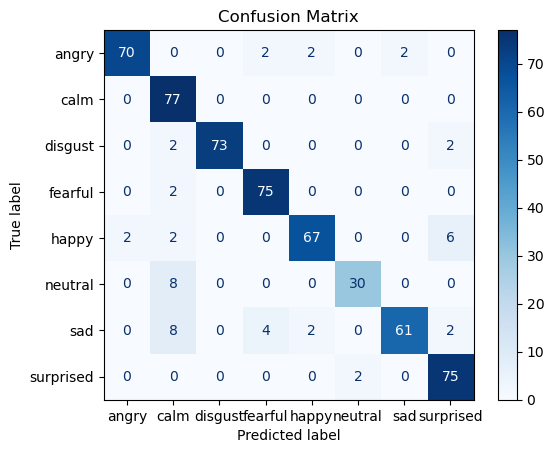

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib
joblib.dump(model, 'emotion_classifier.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
import joblib

# Load your trained model and label encoder (if saved previously)
# model = joblib.load('emotion_classifier.pkl')
# le = joblib.load('label_encoder.pkl')

# Path to new audio file
new_file = './ravdess/Actor_01/03-01-05-01-02-02-01.wav'

# Extract features from the new file
features = extract_features(new_file)

# Reshape for prediction (1 sample)
if features is not None:
    features = features.reshape(1, -1)
    pred_encoded = model.predict(features)
    predicted_emotion = le.inverse_transform(pred_encoded)
    print(f"🎧 Predicted Emotion: {predicted_emotion[0]}")
else:
    print("❌ Could not extract features from the file.")


🎧 Predicted Emotion: angry


In [ ]:
# Save the label encoder from training
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming you already did this during training:
# encoder = LabelEncoder()
# y = encoder.fit_transform(df['emotion'])
# model.fit(X_train, y_train)

def predict_emotion(file_path, model, encoder):
    try:
        # Extract features from the audio file
        features = extract_features(file_path)
        if features is None:
            return "Error: Could not extract features"

        features = np.expand_dims(features, axis=0)  # Make it 2D for prediction
        prediction = model.predict(features)
        predicted_label = encoder.inverse_transform([np.argmax(prediction)]) if hasattr(model, "predict_proba") else encoder.inverse_transform(prediction)
        return predicted_label[0]
    
    except Exception as e:
        return f"Prediction error: {e}"


In [ ]:
# Predict from a new file
file = "./ravdess/Actor_02/03-01-05-01-02-02-02.wav"
print("Predicted Emotion:", predict_emotion(file, model, le))


Predicted Emotion: angry
